In [284]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [285]:
# Load in data

PATH = "../../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=["canceldate", "licence_registration_date", "golive_date"])

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [286]:
# These steps can only be run once then you need to comment them out

#add_datepart(df_raw, 'canceldate')
add_datepart(df_raw, 'licence_registration_date')
add_datepart(df_raw, 'golive_date')

In [287]:
# Drop columns

df_raw = df_raw.drop(columns=['licence_status', 'canceldate', 'cancel_details', 'cancel_reason', 'churned'])

In [288]:
# Set default values for NaN values

df_raw.nps = df_raw.nps.fillna(np.nanmean(df_raw.nps))
df_raw.last_active_days = df_raw.last_active_days.fillna(np.mean(df_raw.last_active_days))
df_raw.churn_concern = df_raw.churn_concern.fillna(0)

In [289]:
# Complete the transformation of all data into numbers using proc_df and create training dataframes
train_cats(df_raw)
df_trn, y_trn, nas = proc_df(df_raw, 'churn_concern', max_n_cat=7)

In [290]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 500
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
X_valid.columns

Index(['username', 'merchant', 'days_active', 'last_active_days', 'nps',
       'team', 'vertical', 'plans', 'plan', 'new_platform', 'salesperson',
       'golive_days', 'url', 'licence_registration_Year',
       'licence_registration_Month', 'licence_registration_Week',
       'licence_registration_Day', 'licence_registration_Dayofweek',
       'licence_registration_Dayofyear', 'licence_registration_Is_month_end',
       'licence_registration_Is_month_start',
       'licence_registration_Is_quarter_end',
       'licence_registration_Is_quarter_start',
       'licence_registration_Is_year_end',
       'licence_registration_Is_year_start', 'licence_registration_Elapsed',
       'golive_Year', 'golive_Month', 'golive_Week', 'golive_Day',
       'golive_Dayofweek', 'golive_Dayofyear', 'golive_Is_month_end',
       'golive_Is_month_start', 'golive_Is_quarter_end',
       'golive_Is_quarter_start', 'golive_Is_year_end', 'golive_Is_year_start',
       'golive_Elapsed', 'account_status_Active

In [291]:
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)
raw_valid.columns

Index(['username', 'merchant', 'days_active', 'last_active_days',
       'account_status', 'nps', 'team', 'vertical', 'plans', 'plan',
       'changing_platform', 'new_platform', 'salesperson', 'golive_days',
       'url', 'churn_concern', 'licence_registration_Year',
       'licence_registration_Month', 'licence_registration_Week',
       'licence_registration_Day', 'licence_registration_Dayofweek',
       'licence_registration_Dayofyear', 'licence_registration_Is_month_end',
       'licence_registration_Is_month_start',
       'licence_registration_Is_quarter_end',
       'licence_registration_Is_quarter_start',
       'licence_registration_Is_year_end',
       'licence_registration_Is_year_start', 'licence_registration_Elapsed',
       'golive_Year', 'golive_Month', 'golive_Week', 'golive_Day',
       'golive_Dayofweek', 'golive_Dayofyear', 'golive_Is_month_end',
       'golive_Is_month_start', 'golive_Is_quarter_end',
       'golive_Is_quarter_start', 'golive_Is_year_end', 'golive_

In [292]:
m = RandomForestClassifier(n_estimators=400, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=5)
m.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

In [293]:
validate_predictions = m.predict(X_valid)

In [294]:
from sklearn.metrics import f1_score, accuracy_score

In [295]:
accuracy_score(y_valid, validate_predictions)

0.962

In [296]:
f1_score(y_valid, validate_predictions)

0.8926553672316385

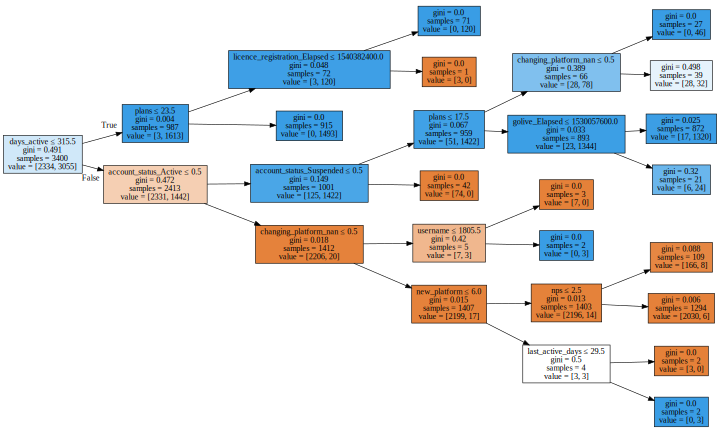

In [297]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [298]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
39,account_status_Active,0.501661
3,last_active_days,0.241430
44,account_status_nan,0.127457
40,account_status_Cancelled,0.033061
47,changing_platform_nan,0.029243
43,account_status_Suspended,0.026234
2,days_active,0.015950
7,plans,0.005777
8,plan,0.004069
9,new_platform,0.003680


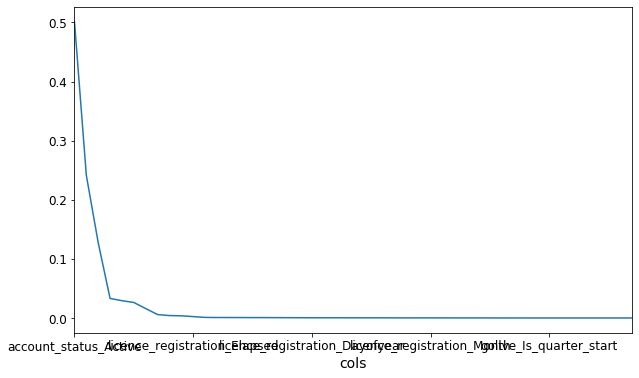

In [299]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [300]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

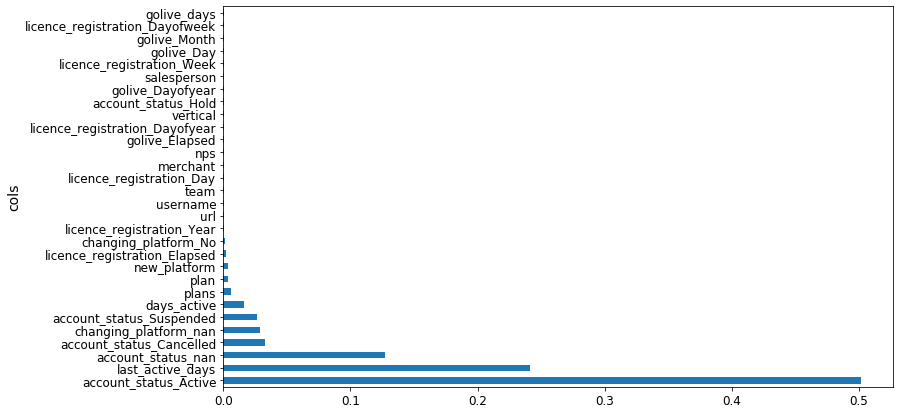

In [301]:
plot_fi(fi[:30]);

In [302]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

8

In [303]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

//anaconda2/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [304]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9926982509763966

In [305]:
(X_train[feats]/1000).describe()

,days_active,account_status_nan,last_active_days
count,5389.000000,5389.000000,5389.000000
mean,0.723994,0.000507,0.026328
std,0.563886,0.000500,0.043064
min,0.000000,0.000000,0.000000
25%,0.244000,0.000000,0.000000
50%,0.604000,0.001000,0.026166
75%,1.094000,0.001000,0.026166
max,2.256000,0.001000,0.417000


In [306]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
6,days_active,0.570554
2,account_status_nan,0.254302
0,account_status_Active,0.078651
1,last_active_days,0.062701
4,changing_platform_nan,0.010184
8,plan,0.008988
7,plans,0.007885
3,account_status_Cancelled,0.005532
5,account_status_Suspended,0.001203


In [307]:
feats=['days_active', 'account_status_nan', 'last_active_days']

In [308]:
(X_train[feats]/1000).describe()

,days_active,account_status_nan,last_active_days
count,5389.000000,5389.000000,5389.000000
mean,0.723994,0.000507,0.026328
std,0.563886,0.000500,0.043064
min,0.000000,0.000000,0.000000
25%,0.244000,0.000000,0.000000
50%,0.604000,0.001000,0.026166
75%,1.094000,0.001000,0.026166
max,2.256000,0.001000,0.417000


In [309]:
(X_valid[feats]/1000).describe()

,days_active,account_status_nan,last_active_days
count,500.000000,500.000000,500.000000
mean,0.152014,0.000056,0.024422
std,0.084335,0.000230,0.047301
min,0.007000,0.000000,0.000000
25%,0.084750,0.000000,0.000000
50%,0.144000,0.000000,0.001000
75%,0.220000,0.000000,0.026166
max,0.311000,0.001000,0.266000


In [310]:
x.drop(feats, axis=1, inplace=True)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9145865172355239

In [311]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
0,account_status_Active,0.304721
5,plan,0.272180
4,plans,0.250718
1,account_status_Cancelled,0.087106
2,changing_platform_nan,0.048769
3,account_status_Suspended,0.036506
